In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/corndiseasedetection/corn_dataset"

In [4]:
image_size = 224
batch_size = 16
channel = 3
n_classes = 4

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4000 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Healthy_Leaf', 'Leaf_Blight', 'Leaf_Rust', 'Leaf_Spot']

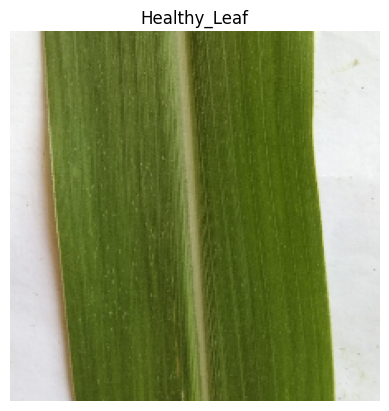

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [8]:
def split_dataset(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=123)
    train_size = int(train_split*dataset_size)
    val_size = int(val_split*dataset_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset , val_dataset , test_dataset = split_dataset(dataset=dataset)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_dataset)

200

In [12]:
len(test_dataset)

25

In [13]:
len(val_dataset)

25

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [15]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, channel)
)

In [17]:
base_model.trainable = False

In [18]:
model = models.Sequential(
    [
        layers.Rescaling(1.0 / 255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

In [19]:
model.build(input_shape=(None,image_size,image_size,channel))

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                      

In [21]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [22]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
200/200 [==============================] - 84s 247ms/step - loss: 1.2859 - accuracy: 0.3853 - val_loss: 1.0060 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - 24s 119ms/step - loss: 0.9446 - accuracy: 0.5953 - val_loss: 0.7732 - val_accuracy: 0.7250 - lr: 1.0000e-04
Epoch 3/50
200/200 [==============================] - 24s 121ms/step - loss: 0.7700 - accuracy: 0.6875 - val_loss: 0.6890 - val_accuracy: 0.6925 - lr: 1.0000e-04
Epoch 4/50
200/200 [==============================] - 25s 124ms/step - loss: 0.6847 - accuracy: 0.7353 - val_loss: 0.6011 - val_accuracy: 0.7525 - lr: 1.0000e-04
Epoch 5/50
200/200 [==============================] - 26s 132ms/step - loss: 0.6096 - accuracy: 0.7534 - val_loss: 0.6271 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 6/50
200/200 [==============================] - 26s 128ms/step - loss: 0.5875 - accuracy: 0.7700 - val_loss: 0.6026 - val_accuracy: 0.7275 - lr: 1.0000e-04
Epoch 7/50
200/200 [========

In [23]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

25/25 [==============================] - 37s 48ms/step - loss: 0.6024 - accuracy: 0.7700
Test Accuracy: 0.7699999809265137


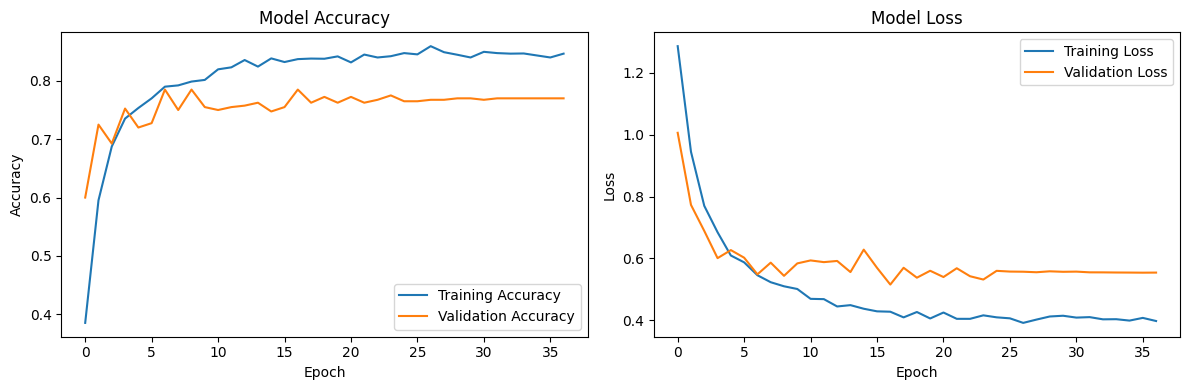

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


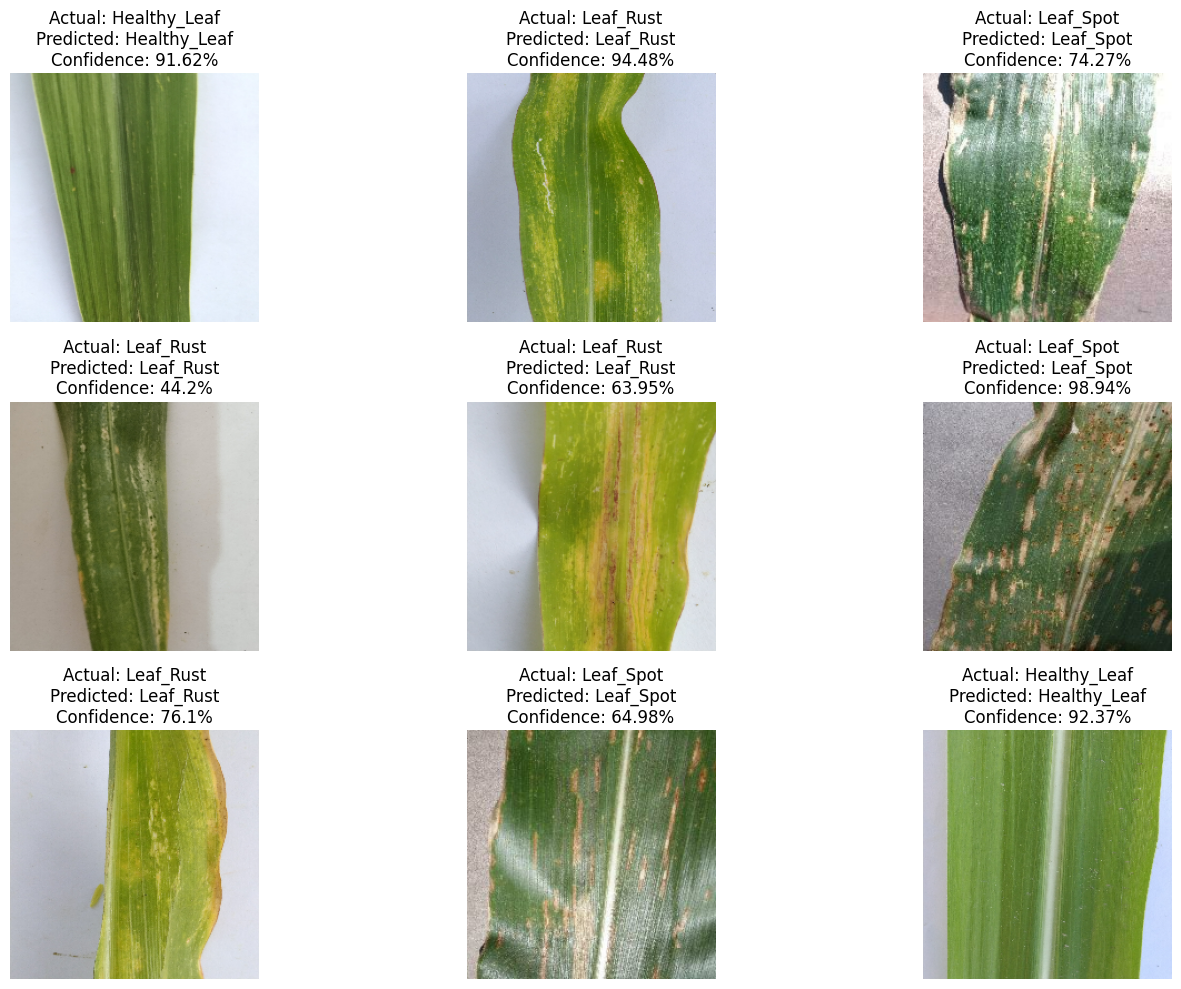

In [26]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 37ms/step


<Figure size 1000x800 with 0 Axes>

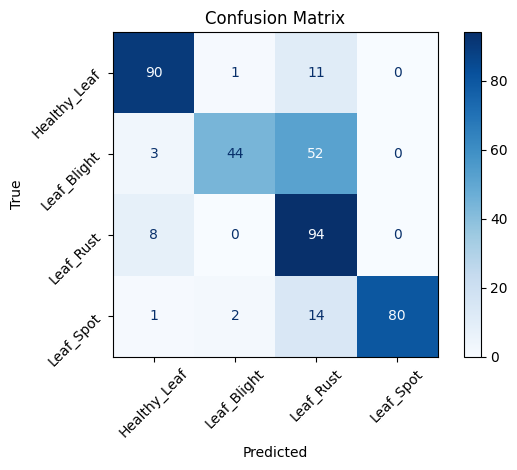

In [27]:
y_true = []
y_pred = []
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

display_labels = [
    'Healthy_Leaf',
    'Leaf_Blight',
    'Leaf_Rust',
    'Leaf_Spot'
]

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("F1 Scores:")
print("Healthy_Leaf:", f1_scores[0])
print("Leaf_Blight:", f1_scores[1])
print("Leaf_Rust:", f1_scores[2])
print("Leaf_Spot:", f1_scores[3])

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)

F1 Scores:
Healthy_Leaf: 0.8823529411764706
Leaf_Blight: 0.6027397260273972
Leaf_Rust: 0.6886446886446885
Leaf_Spot: 0.903954802259887
Macro-averaged F1 Score: 0.7694230395271109


In [29]:
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])
recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("Precision:")
print("Healthy_Leaf:", precision[0])
print("Leaf_Blight:", precision[1])
print("Leaf_Rust:", precision[2])
print("Leaf_Spot:", precision[3])

print("\nRecall:")
print("Healthy_Leaf:", recall[0])
print("Leaf_Blight:", recall[1])
print("Leaf_Rust:", recall[2])
print("Leaf_Spot:", recall[3])

Precision:
Healthy_Leaf: 0.8823529411764706
Leaf_Blight: 0.9361702127659575
Leaf_Rust: 0.5497076023391813
Leaf_Spot: 1.0

Recall:
Healthy_Leaf: 0.8823529411764706
Leaf_Blight: 0.4444444444444444
Leaf_Rust: 0.9215686274509803
Leaf_Spot: 0.8247422680412371


In [30]:
model.save('corndisease_vgg16.h5')

In [31]:
model.save('corndisease_vgg16.keras')